## Journal used for the implemetation
Journal title: Using Convolutional Neural Network for Chest X-ray Image Classification

Authors: Matija Sorić, Danijela Pongrac, Iñaki Inza

Journal Name: MIPRO

Year: 2020

# 1. Import the required libraries

In [39]:
# Importing general libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

# This line allows matplotlib visuals to render within a Jupyter Notebook
%matplotlib inline

# Importing sklearn metrics and ensemble for model evaluation and RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Importing Keras and TensorFlow libraries for deep learning
from keras import regularizers
from keras.models import Sequential
from keras.layers import Flatten, Dropout, Dense, BatchNormalization
from keras.layers import PReLU, Conv2D, SeparableConv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History, EarlyStopping
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# Enabling eager execution for TensorFlow
tf.compat.v1.enable_eager_execution()

# Checking if eager execution is enabled
print(tf.executing_eagerly())

# Setting a seed value for reproducibility of results
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

True


# 2. Data Acquisition

Provide the URL of the data used: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/code


In [11]:
# Define the path to the dataset
input_path = 'C:\\Users\\......\\chest_xray\\'

# Read the files outside the function
normal_test_images = os.listdir(input_path + 'test' + '/NORMAL/')
pneumonia_test_images = os.listdir(input_path + 'test' + '/PNEUMONIA/')

# 3. Data Preparation

Perform the data prepracessing that is required for the data that have downloaded.

In [12]:
def process_images(dimensions, batch, normal_test_images, pneumonia_test_images):
  """
  Preprocesses and prepares the image data for training and testing.

  Args:
    dimensions (int): The desired dimensions for resizing the images.
    batch (int): The batch size for generating the image data.
    normal_test_images (list): List of file names for normal test images.
    pneumonia_test_images (list): List of file names for pneumonia test images.

  Returns:
    tuple: A tuple containing the following elements:
      - train_gen (ImageDataGenerator): Image data generator for training data.
      - test_gen (ImageDataGenerator): Image data generator for testing data.
      - test_data (ndarray): Preprocessed test images.
      - test_labels (ndarray): Labels for the test images.
  """

  # Initialize the ImageDataGenerator for training data with specific augmentations
  train_datagen = ImageDataGenerator(rescale=1./255,
                     zca_whitening=False,
                     horizontal_flip=False,
                     zoom_range=0.5,
                     vertical_flip=True)

  # Initialize the ImageDataGenerator for test/validation data with only rescaling
  test_val_datagen = ImageDataGenerator(rescale=1./255)

  # Generate batches of augmented image data for training
  train_gen = train_datagen.flow_from_directory(directory=input_path + 'train',
                          target_size=(dimensions, dimensions),
                          batch_size=batch,
                          class_mode='binary',
                          shuffle=True)

  # Generate batches of augmented image data for testing
  test_gen = test_val_datagen.flow_from_directory(directory=input_path + 'test',
                          target_size=(dimensions, dimensions),
                          batch_size=batch,
                          class_mode='binary',
                          shuffle=True)

  # Initialize lists to store the preprocessed test images and their labels
  test_data = []
  test_labels = []

  # Loop over the conditions and corresponding image lists
  for condition, images in [('/NORMAL/', normal_test_images), ('/PNEUMONIA/', pneumonia_test_images)]:
    # Loop over the images in the current list
    for image in images:
      # Read the image file
      image = plt.imread(input_path + 'test' + condition + image)
      # Resize the image to the specified dimensions
      image = cv2.resize(image, (dimensions, dimensions))
      # Stack three copies of the image along the third dimension (to create a 3-channel image)
      image = np.dstack([image, image, image])
      # Rescale the pixel values to the range [0, 1]
      image = image.astype('float32') / 255
      # Assign a label to the image based on its condition
      if condition == '/NORMAL/':
        label = 0
      elif condition == '/PNEUMONIA/':
        label = 1

      # Append the processed image and its label to the lists
      test_data.append(image)
      test_labels.append(label)

  # Convert the lists to numpy arrays
  test_data = np.array(test_data)
  test_labels = np.array(test_labels)

  # Return the training and test data generators, as well as the processed test data and labels
  return train_gen, test_gen, test_data, test_labels

# Set the desired dimensions for resizing the images
dimensions = 150
# Set the number of epochs for training
epochs = 11
# Set the batch size for generating the image data
batch = 16

# Call the function with the read files
train_gen, test_gen, test_data, test_labels = process_images(dimensions, batch, normal_test_images, pneumonia_test_images)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 4. Deep Neural Network Architecture


## 4.1 Design the architecture that you will be using

* CNN as per the journal referenced



In [ ]:
# Initialize the model
model = Sequential()

# Add the first convolutional block
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=(150,150,3)))
model.add(Conv2D(16, kernel_size=(3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Add the second convolutional block
model.add(SeparableConv2D(32, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(32, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Add the third convolutional block
model.add(SeparableConv2D(64, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(64, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Add the fourth convolutional block
model.add(SeparableConv2D(128, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(128, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Add the fifth convolutional block
model.add(SeparableConv2D(256, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(SeparableConv2D(256, kernel_size=(3, 3), padding = 'same'))
model.add(PReLU(alpha_initializer="zero"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Add the fully connected block
model.add(Flatten())
model.add(Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.6))
model.add(Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(0.01)))

# Compile the model
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics =['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                             verbose = 1,
                             mode = 'auto',
                             save_best_only=True, 
                             save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, 
                              patience=2, 
                              verbose=1)
history = History()
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.1, patience=3) #zca whitening and early stopping, change

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters



In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 separable_conv2d_8 (Separa  (None, 75, 75, 32)        688       
 bleConv2D)                                                      
                                                                 
 p_re_lu_8 (PReLU)           (None, 75, 75, 32)        180000    
                                                                 
 separable_conv2d_9 (Separa  (None, 75, 75, 32)       

# 5. Training the model


In [15]:
# Fit the model to the training data using a generator
hist = model.fit_generator(
    train_gen,  # The generator that yields batches of training data
    steps_per_epoch = train_gen.samples // batch,  # The number of steps (batches of samples) to yield from the generator before declaring one epoch finished
    epochs = epochs,  # The number of times to iterate over the entire dataset
    validation_data = test_gen,  # The generator that yields batches of validation data
    validation_steps = test_gen.samples // batch,  # The number of steps (batches of samples) to yield from the validation_data generator before stopping at the end of every epoch
    callbacks = [checkpoint, lr_reduce]  # List of callbacks to apply during training
)

Epoch 1/11
326/326 [==============================] - ETA: 0s - loss: 1.1503 - accuracy: 0.8077
Epoch 1: val_loss improved from inf to 0.78236, saving model to weights.01-0.78.hdf5
326/326 [==============================] - 166s 490ms/step - loss: 1.1503 - accuracy: 0.8077 - val_loss: 0.7824 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/11
326/326 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.8612
Epoch 2: val_loss improved from 0.78236 to 0.56174, saving model to weights.02-0.56.hdf5
326/326 [==============================] - 169s 518ms/step - loss: 0.4122 - accuracy: 0.8612 - val_loss: 0.5617 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 3/11
326/326 [==============================] - ETA: 0s - loss: 0.3791 - accuracy: 0.8729
Epoch 3: val_loss improved from 0.56174 to 0.49853, saving model to weights.03-0.50.hdf5
326/326 [==============================] - 167s 513ms/step - loss: 0.3791 - accuracy: 0.8729 - val_loss: 0.4985 - val_accuracy: 0.8734 - lr: 0.0010
Epoch

# 6. Test the model


In [76]:
# Use the model to predict the probabilities for the positive class on the test data
predict_probs = model.predict(test_data)

# Round the predicted probabilities to the nearest integer (0 or 1) to get the predicted classes
predict_classes = np.round(predict_probs).astype(int)

20/20 [==============================] - 4s 177ms/step


# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.


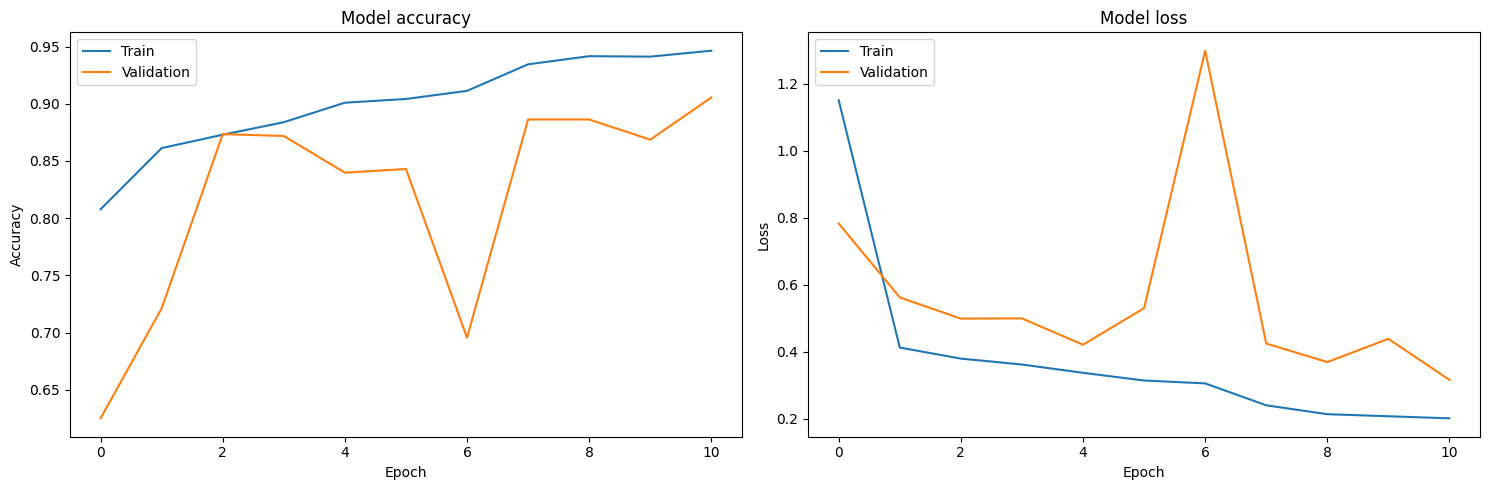

Testing accuracy: 0.9054487347602844, Testing loss: 0.3204965889453888

 Confusion Matrix:


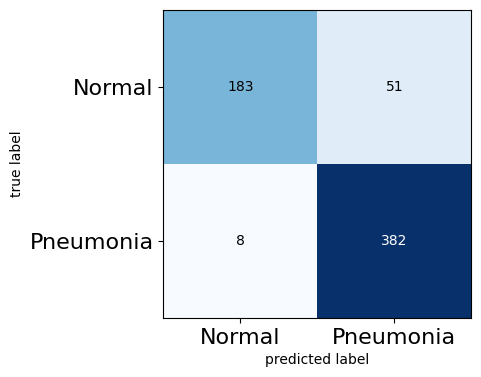

Accuracy: 0.905448717948718
Precision: 0.8822170900692841
Recall: 0.9794871794871794
F1 Score: 0.928311057108141


In [77]:
cm = confusion_matrix(test_labels, np.round(predict_probs))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure and a 1x2 subplot

# 1. Plot the training and validation accuracy history
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# 2. Plot the training and validation loss history
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# 3. Report the testing accuracy and loss
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(f'Testing accuracy: {test_accuracy}, Testing loss: {test_loss}')

# 4. Show Confusion Matrix for testing dataset
print('\n Confusion Matrix:')
plot_confusion_matrix(cm,figsize=(6, 4), hide_ticks=True ,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

# 5. Report values for performance study metrics like accuracy, precision, recall, F1 Score
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")